# IUCN Red List Most Endangered Species Patterns
# Taylor Woodington

In [63]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [64]:
# Load Dataset
df = pd.read_csv(r"C:\Users\Shaun\Downloads\Species.csv")

# Display Data
print(df.head(10))

                 Name   EX  EW  Subtotal (EX+EW) CR(PE)  CR(PEW)  \
0      ACTINOPTERYGII   79  10                89    122        6   
1            AMPHIBIA   35   2                37    146        1   
2            ANTHOZOA    0   0                 0      1        0   
3           ARACHNIDA    9   0                 9     21        0   
4          ASTEROIDEA    0   0                 0      0        0   
5                AVES  159   5               164     22        0   
6            BIVALVIA   32   0                32     15        0   
7        BRANCHIOPODA    0   0                 0      0        0   
8  CEPHALASPIDOMORPHI    1   0                 1      1        0   
9         CEPHALOPODA    0   0                 0      0        0   

  Subtotal (EX+EW+ CR(PE)+CR(PEW))   CR     EN     VU  \
0                              217  626  1,000  1,241   
1                              184  663  1,060    721   
2                                1    6     26    202   
3                      

In [65]:
# Remove missing values
df.dropna(inplace=True)

# Remove the "DD" column
df.drop(columns=["DD"], inplace=True)

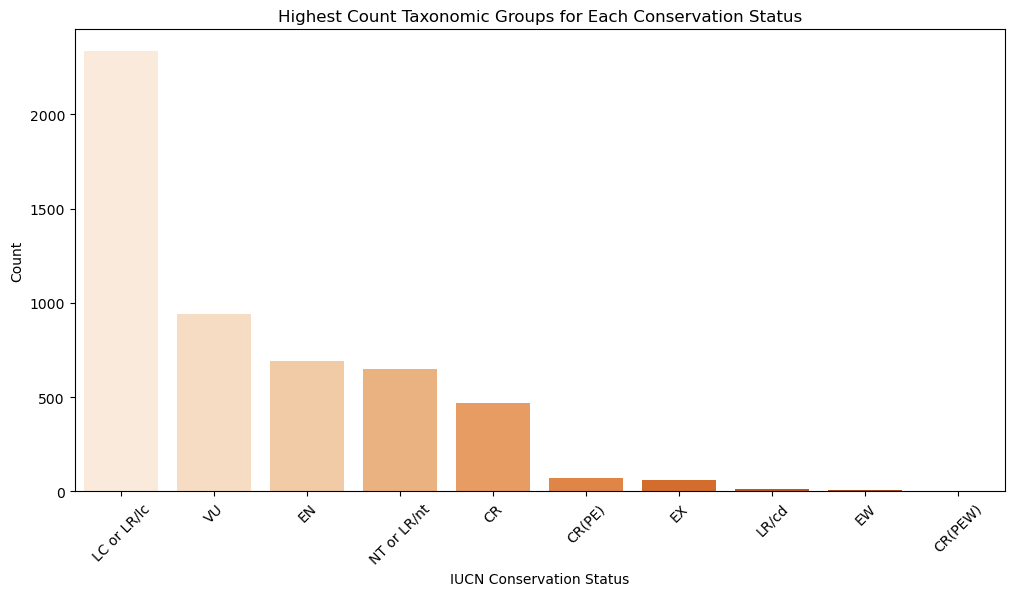

In [66]:
# Convert all numeric columns (except 'Name') to numeric values
for col in df.columns[1:]:  # Excluding 'Name' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values that resulted from conversion
df.dropna(inplace=True)

# Drop the "DD" column if it exists
if "DD" in df.columns:
    df.drop(columns=["DD"], inplace=True)

# Define columns to exclude
exclude_columns = ["Name", "Total", "Subtotal (EX+EW)", "Subtotal (EX+EW+ CR(PE)+CR(PEW))", "Subtotal (threatened spp.)"]

# Select only numeric columns, excluding unnecessary ones
columns_to_sum = [col for col in df.columns if col not in exclude_columns and df[col].dtype in ['int64', 'float64']]

# Sum across conservation categories (excluding "Total" and other subtotals)
status_counts = df[columns_to_sum].sum().sort_values(ascending=False)

# Plot Counts for Taxonomic Groups for Each Status
plt.figure(figsize=(12, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette="Oranges")
plt.xticks(rotation=45)
plt.title("Highest Count Taxonomic Groups for Each Conservation Status")
plt.ylabel("Count")
plt.xlabel("IUCN Conservation Status")
plt.show()

C:\Users\Shaun\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


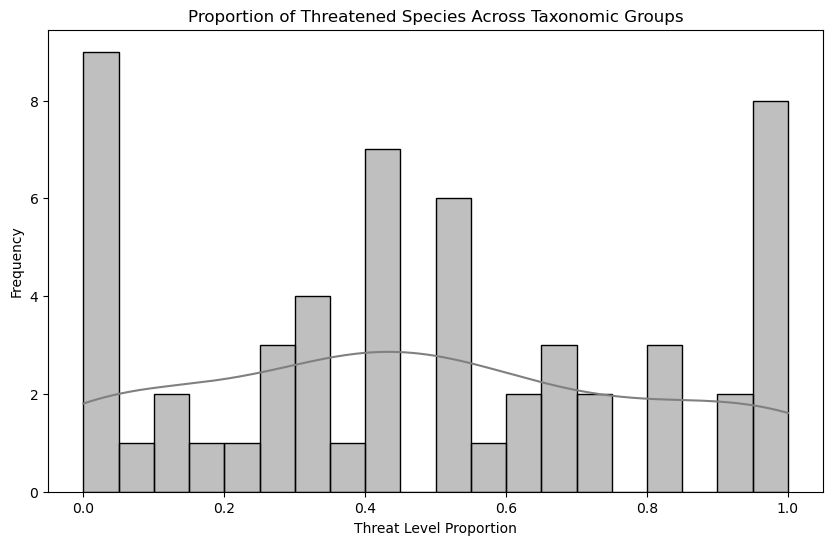

In [67]:
# NOT USED
#Compute proportions
df['Total Threatened'] = df[['CR', 'EN', 'VU']].sum(axis=1)
df['Threat Proportion'] = df['Total Threatened'] / df['Total']

# Proportion of Threatened Species Across Taxonomic Groups
plt.figure(figsize=(10, 6))
sns.histplot(df['Threat Proportion'], bins=20, kde=True, color='grey')
plt.title("Proportion of Threatened Species Across Taxonomic Groups")
plt.xlabel("Threat Level Proportion")
plt.ylabel("Frequency")
plt.show()

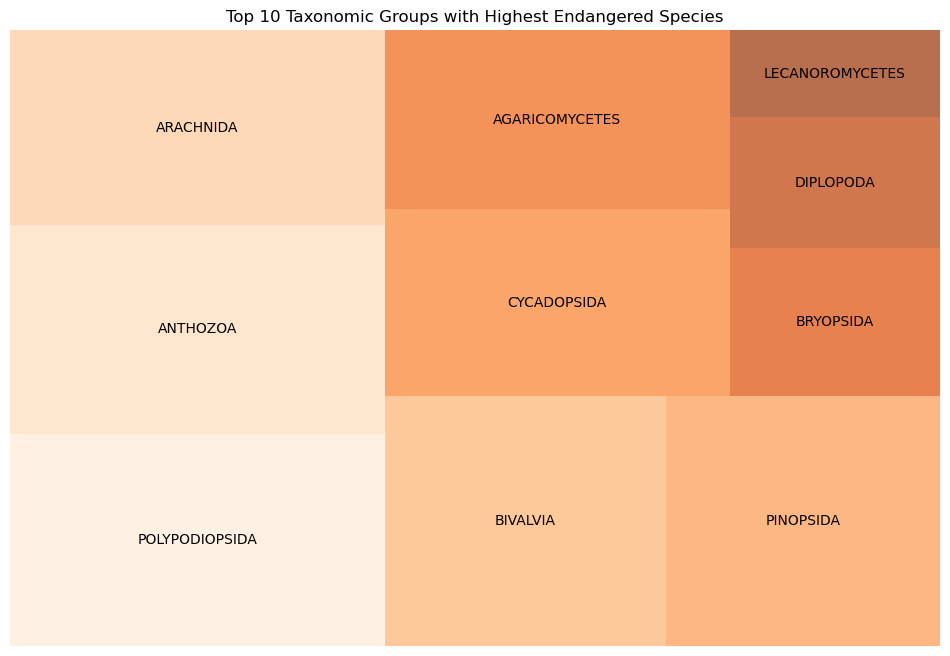

In [68]:
# Aggregate data for treemap
tree_data = df.groupby('Name')['Total Threatened'].sum().reset_index()
tree_data = tree_data.sort_values(by='Total Threatened', ascending=False).head(10)

plt.figure(figsize=(12, 8))
squarify.plot(sizes=tree_data['Total Threatened'], label=tree_data['Name'], alpha=0.7, color=sns.color_palette("Oranges", len(tree_data)))
plt.title("Top 10 Taxonomic Groups with Highest Endangered Species")
plt.axis('off')
plt.show()

In [69]:
# Check differences in threat levels between species groups
anova_result = stats.f_oneway(df['EX'], df['EW'], df['CR'], df['EN'], df['VU'])
print("ANOVA Result:", anova_result)

ANOVA Result: F_onewayResult(statistic=6.496333583891759, pvalue=5.222430136882641e-05)


In [70]:
# Define the target variable: 1 if species is high-risk (CR or EN), 0 otherwise
df['High Risk'] = df[['CR', 'EN']].sum(axis=1) > 0
df['High Risk'] = df['High Risk'].astype(int)

# Encode categorical variables
label_enc = LabelEncoder()
df['Name'] = label_enc.fit_transform(df['Name'])

# Define features and target
X = df[['Name', 'EX', 'EW', 'VU', 'NT or LR/nt', 'LC or LR/lc']]
y = df['High Risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.91      0.95        11

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12



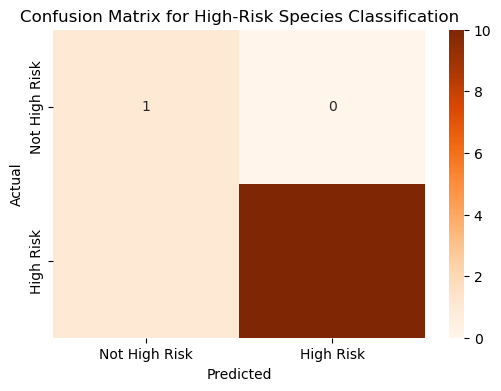

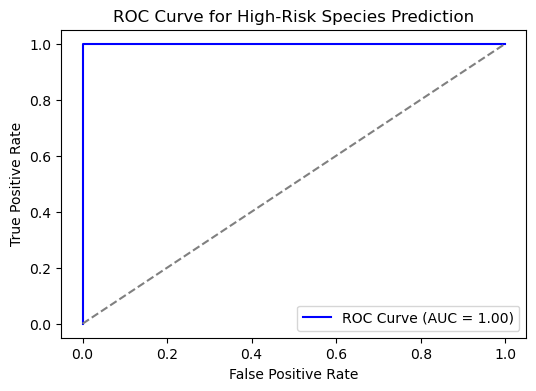

In [71]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Not High Risk", "High Risk"], yticklabels=["Not High Risk", "High Risk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for High-Risk Species Classification")
plt.show()

# ROC Curve

# Get probability scores for positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for High-Risk Species Prediction")
plt.legend()
plt.show()


In [72]:
# Aggregate Data for Answers to Questions
# Critically ENdangered and Endangered
total_CR_EN = df['CR'].sum() + df['EN'].sum()
# CR, EN and VU
total_threatened = total_CR_EN + df['VU'].sum() 
# Least Concern
total_least_concern = df['LC or LR/lc'].sum()

# Print total numbers
print(f"Total Critically Endangered & Endangered: {total_CR_EN}")
print(f"Total Threatened (CR + EN + VU): {total_threatened}")
print(f"Total Least Concern: {total_least_concern}")

Total Critically Endangered & Endangered: 1163.0
Total Threatened (CR + EN + VU): 2105.0
Total Least Concern: 2334.0


In [73]:
# Count of endangered species for the class at the bottom of the top ten compared to the class at the top of the top ten taxonomic groups of high risk
# Aggregate data
tree_data = df.groupby('Name')['Total Threatened'].sum().reset_index()
tree_data = tree_data.sort_values(by='Total Threatened', ascending=False).head(10)  # Top 10 groups

# Get top and bottom of top 10
top_group = tree_data.iloc[0]  # Highest
bottom_group = tree_data.iloc[-1]  # 10th place

# Print results
print(f"Top Taxonomic Group: {top_group['Name']} with {top_group['Total Threatened']} endangered species")
print(f"10th Taxonomic Group: {bottom_group['Name']} with {bottom_group['Total Threatened']} endangered species")

# Difference
difference = top_group['Total Threatened'] - bottom_group['Total Threatened']
print(f"Difference between highest and 10th place: {difference} species")

Top Taxonomic Group: 46.0 with 238.0 endangered species
10th Taxonomic Group: 31.0 with 55.0 endangered species
Difference between highest and 10th place: 183.0 species
